# cygnus-ppf

Sweep Cygnus and my5 with PPF prefetch filtering.

12/12/2023

In [1]:
from collections import defaultdict
from importlib import reload
import json
import os
import sys
from typing import Dict, List, Optional

from matplotlib import colormaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath("../../"))
from plot_utils import collate, plot
from naboo_utils import table

# Configuration

In [2]:
sim_dir = "/u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/"
baseline_study = "baseline"
baseline_experiment = "_baseline"
bandwidths = [200, 3200]
weights_path = "/u/cmolder/GitHub/ChampSim-2022/external/naboo/conf/weights.toml"

suites = [
    "spec06",
    "spec17",
    "gap",
    "cloudsuite",
]
dpi = 192

In [4]:
reload(collate)
studies = {}
for bandwidth in bandwidths:
    print(f"\n=== {bandwidth} MT/s ===")
    core_str = f"default_{bandwidth}"
    core_dir = os.path.join(sim_dir, core_str)

    # my5 threshold sweep
    print(f"~~~ {os.path.join(core_dir, 'my5_accthreshold')} ~~~")
    studies[f"my5_accthreshold__{bandwidth}"] = collate.StudyCollator(
        core_dir, "my5_accthreshold",
        baseline_study=baseline_study,
        baseline_experiment=baseline_experiment,
        weights_path=weights_path,
    )

    # Cygnus threshold sweep
    print(f"~~~ {os.path.join(core_dir, 'cygnus_qvthreshold')} ~~~")
    studies[f"cygnus_qvthreshold__{bandwidth}"] = collate.StudyCollator(
        core_dir, "cygnus_qvthreshold",
        baseline_study=baseline_study,
        baseline_experiment=baseline_experiment,
        weights_path=weights_path,
    )

    # Cygnus/my5 PPF
    print(f"~~~ {os.path.join(core_dir, 'cygnus_ppf')} ~~~")
    studies[f"cygnus_ppf__{bandwidth}"] = collate.StudyCollator(
        core_dir, "cygnus_ppf",
        baseline_study=baseline_study,
        baseline_experiment=baseline_experiment,
        weights_path=weights_path,
    )

    # Baselines
    print(f"~~~ {os.path.join(core_dir, 'prefetchers')} ~~~")
    studies[f"prefetchers__{bandwidth}"] = collate.StudyCollator(
        core_dir, "prefetchers",
        baseline_study=baseline_study,
        baseline_experiment=baseline_experiment,
        weights_path=weights_path,
        experiments=["spp_ppf", "pythia", "my5"],
    )


=== 200 MT/s ===
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_200/my5_accthreshold ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 2813/2813 [00:11<00:00, 239.83file/s]


[ipykernel_launcher][angrist-3] Collating study files...
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_200/cygnus_qvthreshold ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 3395/3395 [00:41<00:00, 82.25file/s] 


[ipykernel_launcher][angrist-3] Collating study files...
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_200/cygnus_ppf ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 388/388 [00:06<00:00, 60.74file/s] 


[ipykernel_launcher][angrist-3] Collating study files...
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_200/prefetchers ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 1129/1129 [00:07<00:00, 152.36file/s]


[ipykernel_launcher][angrist-3] Collating study files...

=== 3200 MT/s ===
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_3200/my5_accthreshold ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 2813/2813 [00:12<00:00, 218.30file/s]


[ipykernel_launcher][angrist-3] Collating study files...
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_3200/cygnus_qvthreshold ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 3395/3395 [00:43<00:00, 77.65file/s]


[ipykernel_launcher][angrist-3] Collating study files...
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_3200/cygnus_ppf ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 388/388 [00:06<00:00, 59.72file/s] 


[ipykernel_launcher][angrist-3] Collating study files...
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_3200/prefetchers ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 1129/1129 [00:08<00:00, 138.91file/s]


[ipykernel_launcher][angrist-3] Collating study files...


# Helper functions

In [5]:
def create_oracle(tabler: table.ChampsimTabler, 
                  oracle_stat: str, 
                  oracle_level: str = "mix", 
                  oracle_method: str = "max",
                  oracle_experiments: Optional[List[str]] = None,):
    """Generate an Oracle.
    """

    oracle_stat_df = None
    if oracle_level == "mix":
        oracle_stat_df = tabler.table_statistic_mix(oracle_stat, experiments=oracle_experiments).T
    elif oracle_level == "benchmark":
        oracle_stat_df = tabler.table_statistic_benchmark(oracle_stat, experiments=oracle_experiments).T
    elif oracle_level == "suite":
        oracle_stat_df = tabler.table_statistic_suite(oracle_stat, experiments=oracle_experiments).T
    elif oracle_level == "overall":
        oracle_stat_df = tabler.table_statistic_overall(oracle_stat, experiments=oracle_experiments).to_frame().T
    else:
        raise NotImplementedError
    
    # Stitch the oracle together
    if oracle_method == "max":
        oracle_value_s = oracle_stat_df.max(axis=1)
        oracle_experiment_s = oracle_stat_df.idxmax(axis=1)
    elif oracle_method == "min":
        oracle_value_s = oracle_stat_df.min(axis=1)
        oracle_experiment_s = oracle_stat_df.idxmin(axis=1)
    else:
        raise NotImplementedError
    
    oracle_df = pd.DataFrame({
        "Value": oracle_value_s,
        "Experiment": oracle_experiment_s
    })
    
    # Return the oracle
    from IPython.display import display
    return oracle_df

def get_oracle_stat(tabler: table.ChampsimTabler, 
                    oracle_df: pd.DataFrame, # Which trace maps to which experiment
                    stat_level: str, # Assumes oracle is per-mix, for now.
                    stat: str,
                    oracle_experiments: Optional[List[str]] = None):
    """Get a particular statistic for an oracle at some level (i.e. mix/benchmark/suite/overall).
    """
    mix_df = tabler.table_statistic_mix(stat, experiments=oracle_experiments).T
    oracle_s = oracle_df["Experiment"]

    mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
    mix_oracle_df = mix_df[["Oracle"]].T
    
    # Compute to the right stat level using the tabler.
    if stat_level == "mix":
        return mix_oracle_df
    
    # Benchmark
    benchmark_oracle_df = tabler.table_statistic_benchmark_(
        stat, mix_oracle_df, ["Oracle"], tabler.get_benchmarks(), 
        use_weights=True)
    if stat_level == "benchmark":
        return benchmark_oracle_df
    
    # Suite
    suite_oracle_df = tabler.table_statistic_suite_(
        stat, benchmark_oracle_df, ["Oracle"], tabler.get_suites())
    if stat_level == "suite":
        return suite_oracle_df
    
    # Overall
    overall_oracle_df = tabler.table_statistic_overall_(
        stat, suite_oracle_df, ["Oracle"])
    if stat_level == "overall":
        return overall_oracle_df
    
    raise NotImplementedError

def get_oracle_table_suite(tabler: table.ChampsimTabler,
                           oracle_experiments: List[str],
                           oracle_stat: str,
                           target_stat: str,
                           oracle_name: Optional[str] = None,
                           add_mean: bool = True):
    """Get the oracle's statistics at the suite level.
    """
    oracle = create_oracle(
        tabler, oracle_stat,
        oracle_level="mix", oracle_method="max",
        oracle_experiments=oracle_experiments
    )
    oracle_stat_suite = get_oracle_stat(
        tabler, oracle, "suite", target_stat,
        oracle_experiments=oracle_experiments
    )

    if add_mean:
        _, fn_mean_str = table._get_stat_avg_fn(target_stat)

        oracle_stat_overall = get_oracle_stat(
            tabler, oracle, "overall", target_stat,
            oracle_experiments=oracle_experiments
        )

        oracle_stat_suite[fn_mean_str] = oracle_stat_overall
    if oracle_name is not None:
        oracle_stat_suite = oracle_stat_suite.rename(index={"Oracle": oracle_name})

    return oracle_stat_suite

def get_oracle_table_benchmark(tabler: table.ChampsimTabler,
                               oracle_experiments: List[str],
                               oracle_stat: str,
                               target_stat: str,
                               suite: Optional[str] = None,
                               oracle_name: Optional[str] = None,
                               add_mean: bool = True):
    """Get the oracle's statistics at the benchmark level.
    """
    oracle = create_oracle(
        tabler, oracle_stat,
        oracle_level="mix", oracle_method="max",
        oracle_experiments=oracle_experiments
    )
    oracle_stat_benchmark = get_oracle_stat(
        tabler, oracle, "benchmark", target_stat,
        oracle_experiments=oracle_experiments
    )
    if suite is not None:
        benchmarks = tabler.get_suite_benchmarks(suite)
        oracle_stat_benchmark = oracle_stat_benchmark[benchmarks]
    if add_mean:
        fn_callable, fn_mean_str = table._get_stat_avg_fn(target_stat)

        oracle_stat_avg = file.avg_fn_wrapper(
            fn_callable, fn_mean_str, oracle_stat_benchmark.values, target_stat.split("."),
            weights=None
        )

        oracle_stat_benchmark[fn_mean_str] = oracle_stat_avg
    if oracle_name is not None:
        oracle_stat_benchmark = oracle_stat_benchmark.rename(index={"Oracle": oracle_name})

    return oracle_stat_benchmark

# Baseline comparison

In [14]:
baseline_df_3200 = {
    "Cygnus (Global Best) (-2)": studies[f"cygnus_qvthreshold__3200"][f"cygnus__-2"],
    "Cygnus (-3)": studies[f"cygnus_qvthreshold__3200"][f"cygnus__-3"],
    "Cygnus+PPF (-3)": studies[f"cygnus_ppf__3200"][f"cygnus__-3"],
    "my5 (Global Best) (30)": studies[f"my5_accthreshold__3200"][f"my5__30"],
    "my5 (51)": studies[f"my5_accthreshold__3200"][f"my5__51"],
    "my5+PPF (51)": studies[f"cygnus_ppf__3200"][f"my5__51"],
    "SPP+PPF": studies[f"prefetchers__3200"][f"spp_ppf"],
    "Pythia": studies[f"prefetchers__3200"][f"pythia"],
}
baseline_df_200 = {
    "Cygnus (Global Best) (8)": studies[f"cygnus_qvthreshold__200"][f"cygnus__8"],
    "Cygnus (-3)": studies[f"cygnus_qvthreshold__200"][f"cygnus__-3"],
    "my5 (Global Best) (75)": studies[f"my5_accthreshold__200"][f"my5__75"],
    "my5 (51)": studies[f"my5_accthreshold__200"][f"my5__51"],
    "SPP+PPF": studies[f"prefetchers__200"][f"spp_ppf"],
    "Pythia": studies[f"prefetchers__200"][f"pythia"],
}

baseline_colors = {
    "Cygnus (Per-Trace Best)": colormaps["Set3"](0),
    "Cygnus (Global Best) (-2)": colormaps["Set3"](0),
    "Cygnus (Global Best) (8)": colormaps["Set3"](0),
    "Cygnus (-3)": colormaps["Set3"](0),
    "my5 (Per-Trace Best)": colormaps["Set3"](9),
    "my5 (Global Best) (30)": colormaps["Set3"](9),
    "my5 (Global Best) (75)": colormaps["Set3"](9),
    "my5 (51)": colormaps["Set3"](9),
    "my5"    : colormaps["Set3"](9),
    "Pythia" : colormaps["Set3"](2),
    "SPP+PPF": colormaps["Set3"](6),
}
baseline_hatches = {
    "Cygnus (Per-Trace Best)": "xxxx",
    "Cygnus (Global Best) (-2)": "////",
    "Cygnus (Global Best) (8)": "////",
    "Cygnus (-3)": "",
    "Cygnus (Bandit)": "..",
    "my5 (Per-Trace Best)": "xxxx",
    "my5 (Global Best) (30)": "////",
    "my5 (Global Best) (75)": "////",
    "my5 (51)": "",
    "Pythia" : "",
    "SPP+PPF": "",
}
baseline_legend_kwargs = {
    "ncol": 3,
    "fontsize": 6.75,
    "loc": "lower center",
    "bbox_to_anchor": (0.5, 1.0),
    "framealpha": 0,
}
baseline_label_kwargs = {
    "rotation": 0,
    "ha": "center",
    "fontsize": 7,
}

## 3200 MT/s

### IPC improvement

In [12]:
reload(plot)
baseline_3200__suite__ipc = plot.get_suite_table(baseline_df_3200, "cpu.gmean.ipc_improvement", 
                                             suites=suites, add_mean=True)

# Cygnus (Best Per-Trace Static)
cygnus_oracle_3200__suite__ipc = get_oracle_table_suite(
    studies[f"cygnus_qvthreshold__3200"].tabler,
    oracle_experiments=studies[f"cygnus_qvthreshold__3200"].study.experiments,
    oracle_name="Cygnus (Per-Trace Best)",
    oracle_stat="cpu.gmean.ipc_improvement",
    target_stat="cpu.gmean.ipc_improvement",
    add_mean=True
)

# my5 (Best Per-Trace Static)
my5_oracle_3200__suite__ipc = get_oracle_table_suite(
    studies[f"my5_accthreshold__3200"].tabler,
    oracle_experiments=studies[f"my5_accthreshold__3200"].study.experiments,
    oracle_name="my5 (Per-Trace Best)",
    oracle_stat="cpu.gmean.ipc_improvement",
    target_stat="cpu.gmean.ipc_improvement",
    add_mean=True
)

baseline_3200__suite__ipc = pd.concat([
    cygnus_oracle_3200__suite__ipc,
    my5_oracle_3200__suite__ipc,
    baseline_3200__suite__ipc,
])
baseline_3200__suite__ipc = baseline_3200__suite__ipc.reindex([
    "Cygnus (Per-Trace Best)",
    "Cygnus (Global Best) (-2)",
    "Cygnus (-3)",
    "my5 (Per-Trace Best)",
    "my5 (Global Best) (30)",
    "my5 (51)",
    "SPP+PPF",
    "Pythia",
])
baseline_3200__suite__ipc

/tmp/ipykernel_1007985/2861016523.py:50: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_1007985/2861016523.py:50: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_1007985/2861016523.py:50: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_1007985/2861016523.py:50: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix

,spec06,cloudsuite,spec17,gap,gmean
Cygnus (Per-Trace Best),37.812217,14.390129,26.908574,23.337722,25.333102
Cygnus (Global Best) (-2),34.252495,10.741114,25.804238,21.877458,22.874702
Cygnus (-3),34.157117,10.803229,25.502473,22.131828,22.860370
my5 (Per-Trace Best),32.219253,11.038293,22.846587,22.042279,21.803627
my5 (Global Best) (30),31.316243,8.783289,21.484827,21.117952,20.407294
my5 (51),29.599785,8.459003,21.963025,18.411394,19.363870
SPP+PPF,32.208799,7.766227,22.860580,18.423648,19.990955
Pythia,26.610409,7.597408,20.813901,19.632290,18.456565


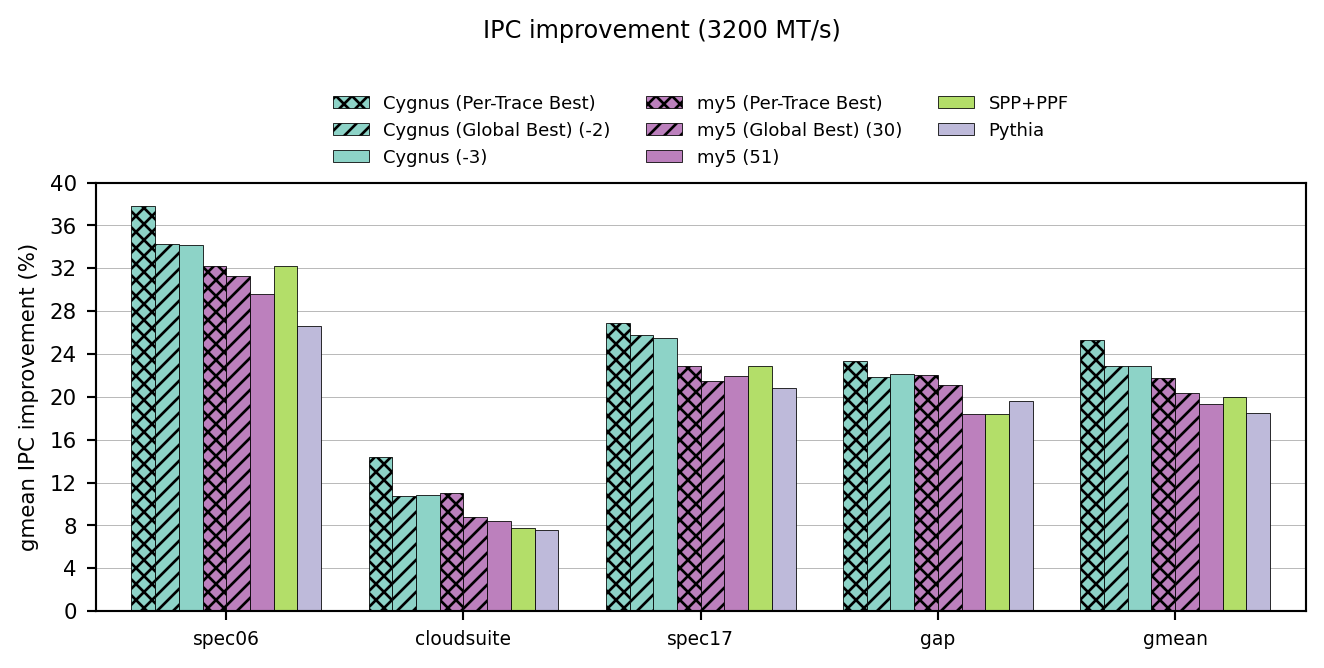

In [15]:
reload(plot)                                             
plot.plot_table(baseline_3200__suite__ipc,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    add_suptitle=True,    
    suptitle="IPC improvement (3200 MT/s)",
    add_xlabel=False,
    ylabel="gmean IPC improvement (%)",
    ylim=(0, 40),
    ytick_distance=4,
    dpi=192, figsize=(7, 3.5))
plt.savefig("threshold_sweep_3200_baseline_ipc.png", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_baseline_ipc.pdf", dpi=dpi, bbox_inches="tight")

### Accuracy

In [27]:
reload(plot)
plot.get_suite_table(
    baseline_df_3200, 
    "cache.L2C.amean.prefetch_accuracy_timely", 
    suites=suites)

,spec06,spec17,gap,cloudsuite,amean
Cygnus (Global Best) (-2),36.214636,33.199998,24.437919,20.436815,28.572342
Cygnus (-3),35.171950,32.856266,23.802760,18.913619,27.686149
my5 (Global Best) (30),14.654850,NaN,13.149772,9.341587,NaN
my5 (51),15.934711,NaN,12.611549,9.976853,NaN
SPP+PPF,43.100879,35.642329,35.568776,29.159828,35.867953
Pythia,22.703303,15.874125,19.602071,17.831714,19.002803


In [28]:
reload(plot)
plot.get_suite_table(
    baseline_df_3200, 
    "cache.L2C.amean.prefetch_accuracy", 
    suites=suites)

,spec06,spec17,gap,cloudsuite,amean
Cygnus (Global Best) (-2),43.956465,35.953084,25.352831,22.459759,31.930535
Cygnus (-3),42.536323,35.351583,24.664719,20.693707,30.811583
my5 (Global Best) (30),18.294070,NaN,13.425430,10.275938,NaN
my5 (51),19.783909,NaN,13.082127,11.103441,NaN
SPP+PPF,55.099585,42.062519,37.803004,33.338318,42.075856
Pythia,30.957579,19.556014,20.449345,20.203094,22.791508


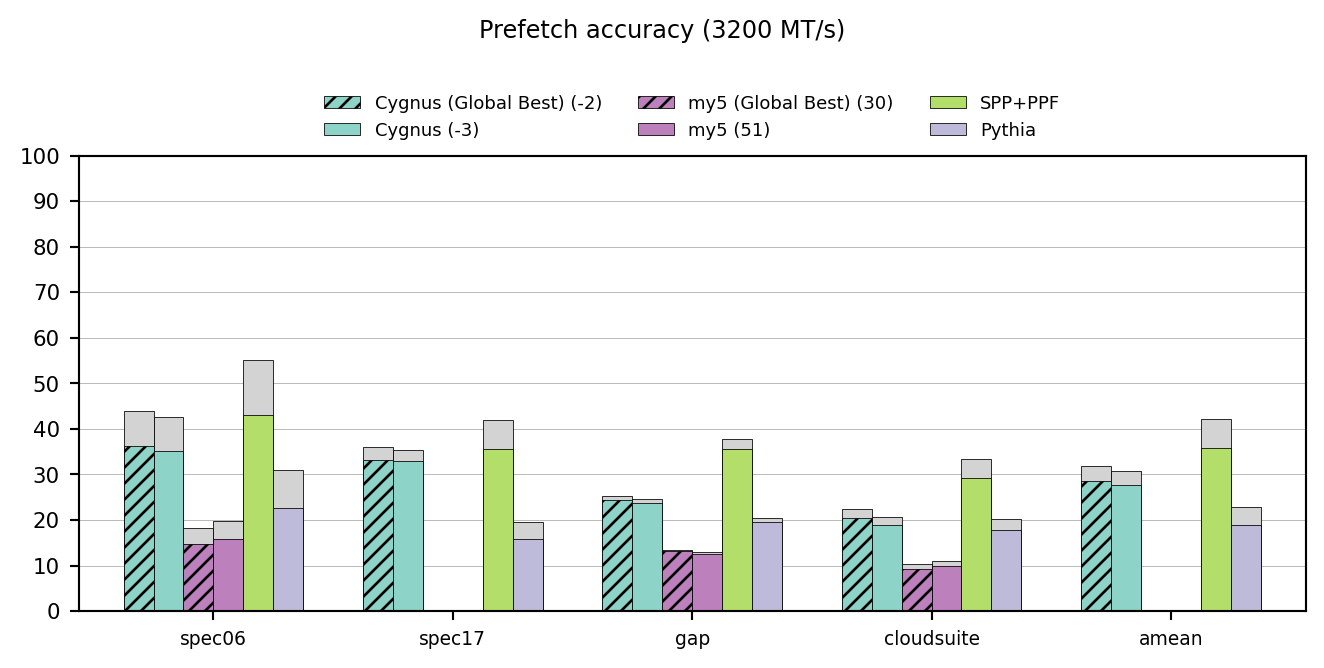

In [25]:
plot.plot_suite_statistic(
    baseline_df_3200,
    "cache.L2C.amean.prefetch_accuracy_timely",
    secondary_statistic_names=["cache.L2C.amean.prefetch_accuracy"],
    suites=suites,
    add_mean=True,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    suptitle="Prefetch accuracy (3200 MT/s)",
    add_suptitle=True,
    add_xlabel=False,
    ylim=(0, 100),
    ytick_distance=10,
    dpi=192, figsize=(7, 3.5))

### Coverage

In [32]:
reload(plot)
plot.get_suite_table(
    baseline_df_3200, 
    "cache.L2C.amean.prefetch_coverage_untimely",
    suites=suites)

,spec06,spec17,gap,cloudsuite,amean
Cygnus (Global Best) (-2),53.046836,32.174318,46.254599,43.912600,43.847088
Cygnus (-3),53.366155,30.401598,46.607092,44.162417,43.634316
my5 (Global Best) (30),50.637053,15.818064,45.881956,38.425203,37.690569
my5 (51),48.898944,34.249697,44.655563,34.820019,40.656056
SPP+PPF,52.528626,21.887015,44.613806,37.650820,39.170067
Pythia,47.631498,31.077882,44.370993,36.338066,39.854610


In [33]:
reload(plot)
plot.get_suite_table(
    baseline_df_3200, 
    "cache.L2C.amean.prefetch_coverage",
    suites=suites)

,spec06,spec17,gap,cloudsuite,amean
Cygnus (Global Best) (-2),44.138166,28.368000,43.319148,37.195902,38.255304
Cygnus (-3),44.531293,26.658095,43.500184,37.491336,38.045227
my5 (Global Best) (30),40.799218,11.482812,43.309821,34.029110,32.405240
my5 (51),39.177402,31.440470,42.777651,30.780367,36.043972
SPP+PPF,41.391320,14.112551,41.252185,30.393597,31.787413
Pythia,35.317968,24.290540,40.534427,29.402985,32.386480


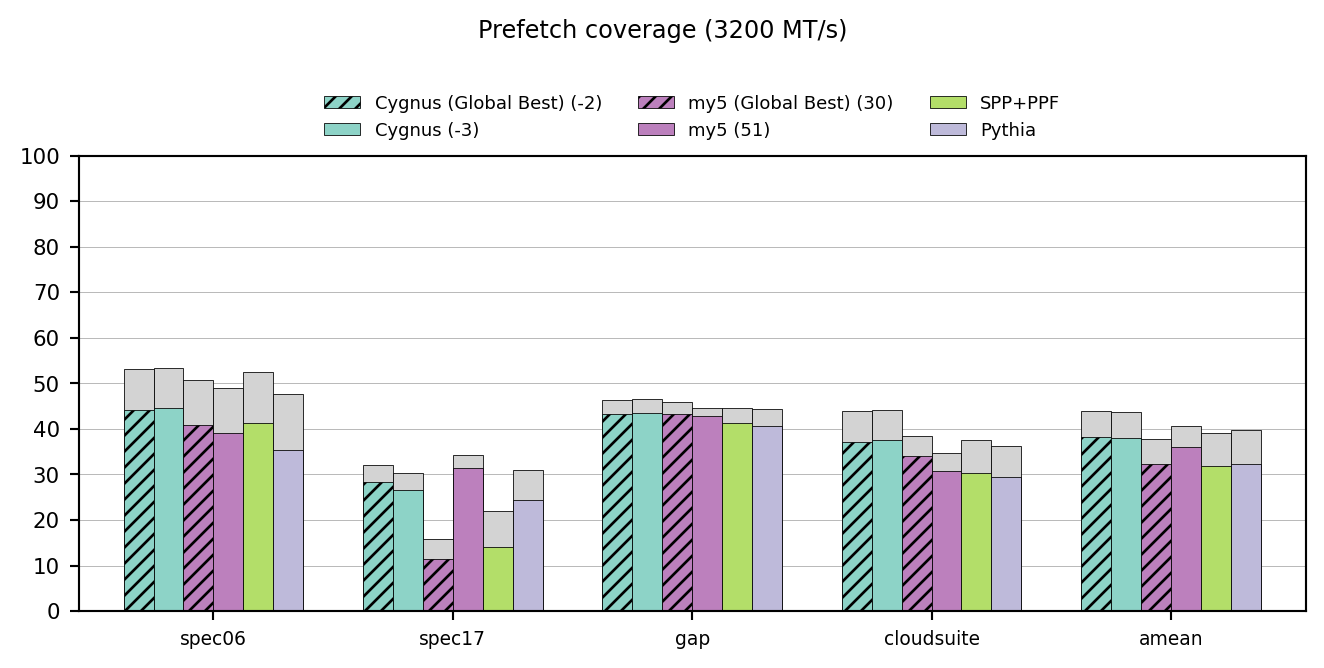

In [30]:
plot.plot_suite_statistic(
    baseline_df_3200,
    "cache.L2C.amean.prefetch_coverage",
    secondary_statistic_names=["cache.L2C.amean.prefetch_coverage_untimely"],
    suites=suites,
    add_mean=True,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    suptitle="Prefetch coverage (3200 MT/s)",
    add_suptitle=True,
    add_xlabel=False,
    ylim=(0, 100),
    ytick_distance=10,
    dpi=192, figsize=(7, 3.5))

### Prefetch classification

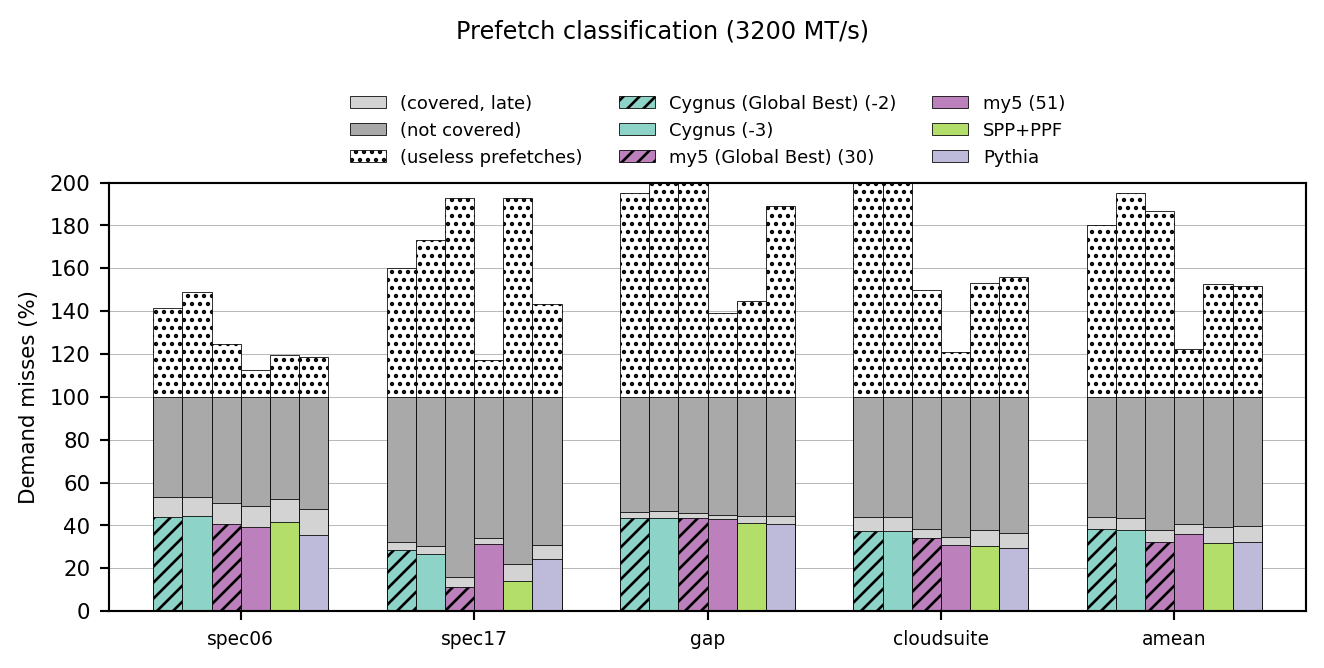

In [16]:
reload(plot)
plot.plot_suite_overpredictions(
    baseline_df_3200,
    suites=suites,
    add_mean=True,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    suptitle="Prefetch classification (3200 MT/s)",
    add_suptitle=True,
    add_xlabel=False,
    ylim=(0, 200),
    ytick_distance=20,
    dpi=192, figsize=(7, 3.5))
plt.savefig("threshold_sweep_3200_baseline_classification.png", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_baseline_classification.pdf", dpi=dpi, bbox_inches="tight")

## 200 MT/s

### IPC improvement

In [34]:
reload(plot)
baseline_200__suite__ipc = plot.get_suite_table(baseline_df_200, "cpu.gmean.ipc_improvement", 
                                             suites=suites, add_mean=True)

# Cygnus (Best Per-Trace Static)
cygnus_oracle_200__suite__ipc = get_oracle_table_suite(
    studies[f"cygnus_qvthreshold__200"].tabler,
    oracle_experiments=studies[f"cygnus_qvthreshold__200"].study.experiments,
    oracle_name="Cygnus (Per-Trace Best)",
    oracle_stat="cpu.gmean.ipc_improvement",
    target_stat="cpu.gmean.ipc_improvement",
    add_mean=True
)

# my5 (Best Per-Trace Static)
my5_oracle_200__suite__ipc = get_oracle_table_suite(
    studies[f"my5_accthreshold__200"].tabler,
    oracle_experiments=studies[f"my5_accthreshold__200"].study.experiments,
    oracle_name="my5 (Per-Trace Best)",
    oracle_stat="cpu.gmean.ipc_improvement",
    target_stat="cpu.gmean.ipc_improvement",
    add_mean=True
)

baseline_200__suite__ipc = pd.concat([
    cygnus_oracle_200__suite__ipc,
    my5_oracle_200__suite__ipc,
    baseline_200__suite__ipc,
])
baseline_200__suite__ipc = baseline_200__suite__ipc.reindex([
    "Cygnus (Per-Trace Best)",
    "Cygnus (Global Best) (8)",
    "Cygnus (-3)",
    "my5 (Per-Trace Best)",
    "my5 (Global Best) (75)",
    "my5 (51)",
    "SPP+PPF",
    "Pythia",
])
baseline_200__suite__ipc

/tmp/ipykernel_1007985/2861016523.py:50: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_1007985/2861016523.py:50: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_1007985/2861016523.py:50: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_1007985/2861016523.py:50: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix

,spec06,cloudsuite,spec17,gap,gmean
Cygnus (Per-Trace Best),9.627747,7.293700,12.645279,33.530470,15.331256
Cygnus (Global Best) (8),7.045087,5.138191,10.055331,32.250233,13.131538
Cygnus (-3),0.025962,-10.298429,6.083281,19.915836,3.361563
my5 (Per-Trace Best),10.876211,8.368568,13.822531,31.150685,15.727115
my5 (Global Best) (75),9.149857,6.403994,13.175973,28.975014,14.106460
my5 (51),7.804244,4.691859,12.859603,27.727343,12.938702
SPP+PPF,6.158251,-0.632222,10.074553,28.332860,10.485691
Pythia,6.634564,0.782206,9.004599,28.220061,10.705874


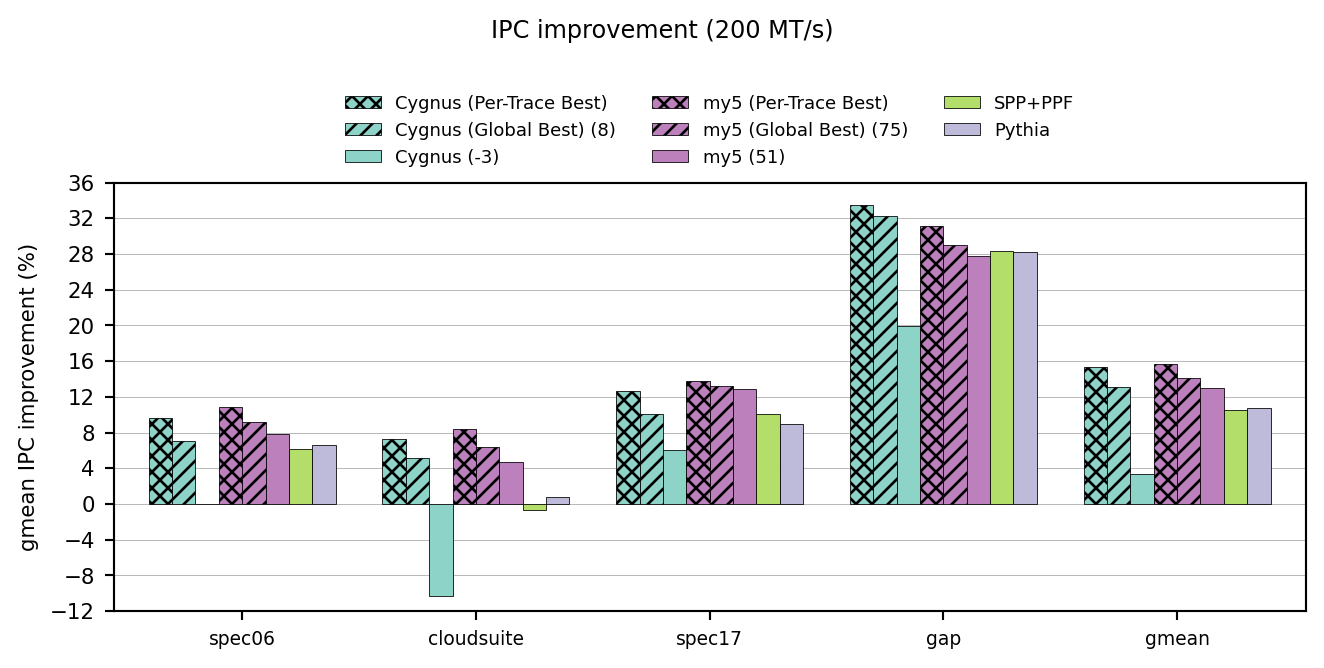

In [35]:
reload(plot)
plot.plot_table(baseline_200__suite__ipc,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    add_suptitle=True,
    suptitle="IPC improvement (200 MT/s)",
    add_xlabel=False,
    ylabel="gmean IPC improvement (%)",
    ylim=(-12, 36),
    ytick_distance=4,
    dpi=192, figsize=(7, 3.5))
plt.savefig("threshold_sweep_200_baseline_ipc.png", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_baseline_ipc.pdf", dpi=dpi, bbox_inches="tight")

### Accuracy

In [36]:
reload(plot)
plot.get_suite_table(
    baseline_df_200, 
    "cache.L2C.amean.prefetch_accuracy_timely", 
    suites=suites)

,spec06,spec17,gap,cloudsuite,amean
Cygnus (Global Best) (8),36.430092,25.093491,26.816769,25.999673,28.585006
Cygnus (-3),31.783666,27.501758,20.332902,17.052544,24.167717
my5 (Global Best) (75),15.284795,NaN,13.280114,9.798664,NaN
my5 (51),14.426596,NaN,12.845078,9.687494,NaN
SPP+PPF,34.651776,25.891379,28.099334,24.606602,28.312273
Pythia,19.158932,14.139994,17.502538,16.000238,16.700426


In [37]:
reload(plot)
plot.get_suite_table(
    baseline_df_200, 
    "cache.L2C.amean.prefetch_accuracy", 
    suites=suites)

,spec06,spec17,gap,cloudsuite,amean
Cygnus (Global Best) (8),58.698172,39.805551,34.236993,36.655461,42.349044
Cygnus (-3),45.415114,36.080923,25.236770,21.132835,31.966410
my5 (Global Best) (75),27.301550,NaN,18.946736,13.391868,NaN
my5 (51),26.028929,NaN,16.803116,13.051928,NaN
SPP+PPF,56.367409,42.773233,37.612024,33.350023,42.525672
Pythia,35.093936,23.177302,22.064543,22.130436,25.616554


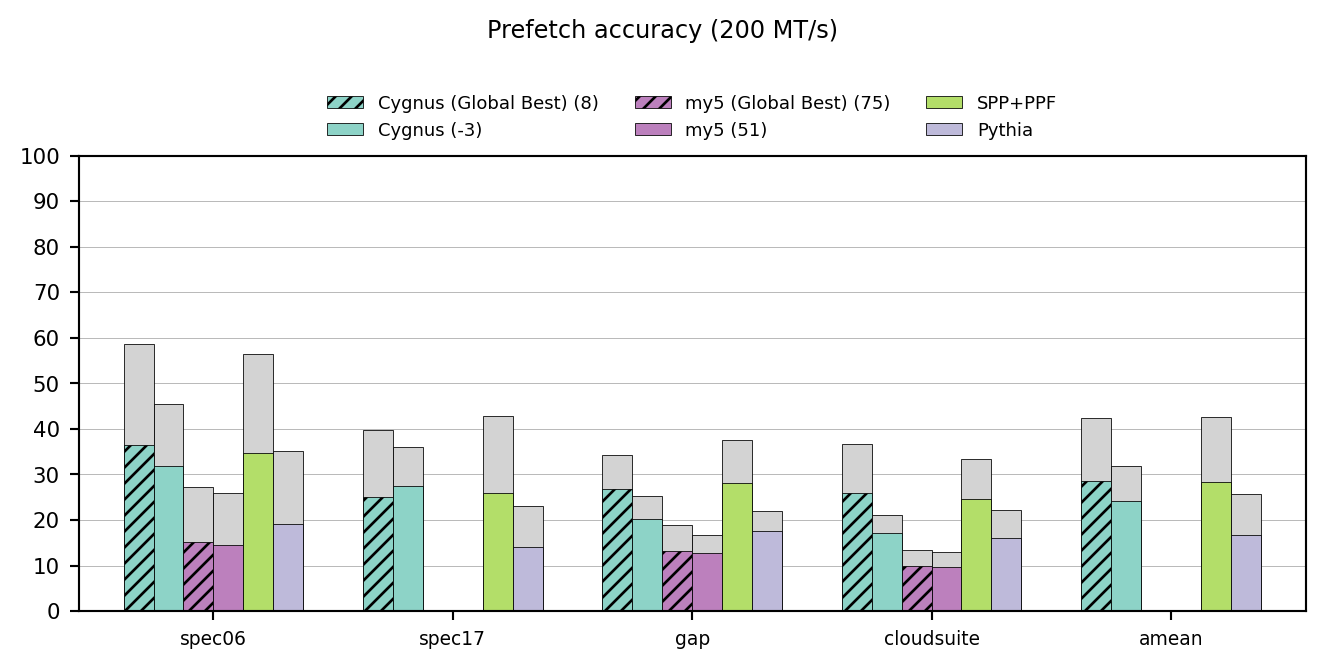

In [41]:
plot.plot_suite_statistic(
    baseline_df_200,
    "cache.L2C.amean.prefetch_accuracy_timely",
    secondary_statistic_names=["cache.L2C.amean.prefetch_accuracy"],
    suites=suites,
    add_mean=True,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    suptitle="Prefetch accuracy (200 MT/s)",
    add_suptitle=True,
    add_xlabel=False,
    ylim=(0, 100),
    ytick_distance=10,
    dpi=192, figsize=(7, 3.5))

### Coverage

In [38]:
reload(plot)
plot.get_suite_table(
    baseline_df_200, 
    "cache.L2C.amean.prefetch_coverage_untimely", 
    suites=suites)

,spec06,spec17,gap,cloudsuite,amean
Cygnus (Global Best) (8),43.888917,27.813594,43.109406,30.810386,36.405576
Cygnus (-3),50.860459,25.569415,46.536972,43.637536,41.651095
my5 (Global Best) (75),46.451504,36.978153,42.230515,32.571197,39.557842
my5 (51),48.819736,34.151894,44.630257,34.777491,40.594845
SPP+PPF,52.192927,22.051177,44.444873,37.496895,39.046468
Pythia,46.598749,28.721396,44.612590,36.253905,39.046660


In [39]:
reload(plot)
plot.get_suite_table(
    baseline_df_200, 
    "cache.L2C.amean.prefetch_coverage", 
    suites=suites)

,spec06,spec17,gap,cloudsuite,amean
Cygnus (Global Best) (8),25.795062,12.153902,29.861533,19.471172,21.820417
Cygnus (-3),34.494507,12.897589,31.117183,29.694832,27.051028
my5 (Global Best) (75),28.958102,20.625268,30.731820,23.756137,26.017831
my5 (51),30.810548,17.512617,32.062621,25.131605,26.379348
SPP+PPF,31.789876,0.734234,29.351723,23.673543,21.387344
Pythia,26.504960,7.418828,28.159452,21.715534,20.949693


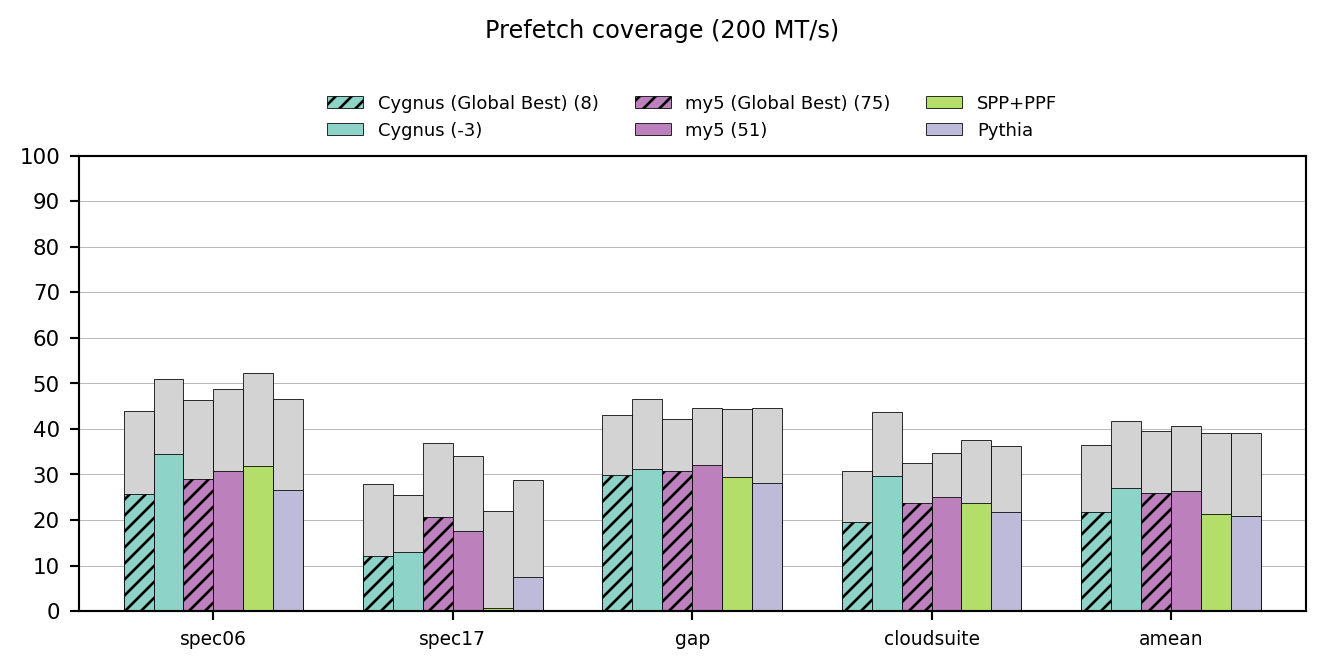

In [40]:
plot.plot_suite_statistic(
    baseline_df_200,
    "cache.L2C.amean.prefetch_coverage",
    secondary_statistic_names=["cache.L2C.amean.prefetch_coverage_untimely"],
    suites=suites,
    add_mean=True,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    suptitle="Prefetch coverage (200 MT/s)",
    add_suptitle=True,
    add_xlabel=False,
    ylim=(0, 100),
    ytick_distance=10,
    dpi=192, figsize=(7, 3.5))

### Prefetch classification

In [ ]:
reload(plot)
plot.plot_suite_overpredictions(
    baseline_df_200,
    suites=suites,
    add_mean=True,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    suptitle="Prefetch classification (200 MT/s)",
    add_suptitle=True,
    add_xlabel=False,
    ylim=(0, 200),
    ytick_distance=20,
    dpi=192, figsize=(7, 3.5))
plt.savefig("threshold_sweep_200_baseline_classification.png", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_baseline_classification.pdf", dpi=dpi, bbox_inches="tight")